In [2]:
import jax
import equinox as eqx
import jax.numpy as jnp
import jax.random as jrandom
import optimistix as optx
import optax

jax.config.update('jax_enable_x64', True)

In [3]:
# !pip install --upgrade optax

In [4]:
!pip install --upgrade equinox

/home/asem/GP/env/icenode-dev/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [5]:
key = jrandom.PRNGKey(0)
IN = 10
OUT = 50

mlp = eqx.nn.MLP(IN, OUT, depth=3, width_size=OUT, key=key)



2024-05-16 14:49:08.380395: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [6]:
?optx.fixed_point

Signature:      
optx.fixed_point(
    fn: Union[collections.abc.Callable[[~Y, Any], tuple[~Y, ~Aux]], collections.abc.Callable[[~Y, Any], ~Y]],
    solver: Union[optimistix._fixed_point.AbstractFixedPointSolver, optimistix._root_find.AbstractRootFinder, optimistix._least_squares.AbstractLeastSquaresSolver, optimistix._minimise.AbstractMinimiser],
    y0: ~Y,
    args: jaxtyping.PyTree[typing.Any] = None,
    options: Optional[dict[str, Any]] = None,
    *,
    has_aux: bool = False,
    max_steps: Optional[int] = 256,
    adjoint: optimistix._adjoint.AbstractAdjoint = ImplicitAdjoint(linear_solver=AutoLinearSolver(well_posed=None)),
    throw: bool = True,
    tags: frozenset[object] = frozenset(),
) -> optimistix._solution.Solution[~Y, ~Aux]
Call signature:  optx.fixed_point(*args, **kwargs)
Type:            _JitWrapper
String form:    
_JitWrapper(
  fn='fixed_point',
  filter_warning=False,
  donate_first=False,
  donate_rest=False
)
File:            ~/GP/env/icenode-dev/lib/python

In [7]:
import pandas as pd
from datetime import datetime 
from tqdm import tqdm

@eqx.filter_jit
def reconstruction_loss(z, mlp_mask_x):  # contractive map
    mlp, mask, x = mlp_mask_x
    x_hat = mlp(z)
    loss = jnp.sqrt(jnp.nanmean((x - x_hat)**2, where=mask))
    return loss, loss

solver = {
    'cg': optx.BestSoFarMinimiser(optx.NonlinearCG(rtol=1e-8, atol=1e-8)),
    # 'optax': optx.BestSoFarMinimiser(optx.OptaxMinimiser(optim=optax.adam(1e-3), rtol=1e-8, atol=1e-8)),
    'BFGS': optx.BestSoFarMinimiser(optx.BFGS(rtol=1e-8, atol=1e-8))
}

@eqx.filter_jit
def solve(solver, z_init, args):
    return optx.minimise(reconstruction_loss, solver=solver, y0=z_init, args=args, throw=True,
                             has_aux=True,
                             max_steps=None)

@eqx.filter_jit
def loss(mlp, z_init, mask, x):
    z = solve(optx.BestSoFarMinimiser(optx.BFGS(rtol=1e-8, atol=1e-8)), 
              z_init, (mlp, mask, x)).value
    return jnp.nanmean((x - mlp(z)) ** 2, where=mask)

df = []
for i in tqdm(range(100)):
    key, _ = jrandom.split(key, 2)
    z_init = jrandom.normal(key, shape=(IN, ))
    mask = jrandom.bernoulli(key, shape=(OUT, ))
    x = jrandom.normal(key, shape=(OUT, ))
    g = eqx.filter_grad(loss)(mlp, z_init, mask, x)

    # init_loss = reconstruction_loss(z_init, (mlp, mask, x))[0]    
    # for solver_k, solver_v in solver.items():
        
    #     timenow = datetime.now()
    #     solution = solve(solver_v, z_init, (mlp, mask, x))
    #     eval_time = (datetime.now() - timenow).total_seconds()
    #     loss_reduction = init_loss - solution.aux

    #     df.append((i, solver_k, eval_time, loss_reduction.item()))
    
    # print(solution.value)
    # print(solution.stats)


100%|███████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.22it/s]


In [8]:
df = pd.DataFrame(df, columns=['iteration', 'solver', 'duration', 'reduction'])

In [9]:
df = df.astype({'reduction': float})

IndexError: cannot do a non-empty take from an empty axes.

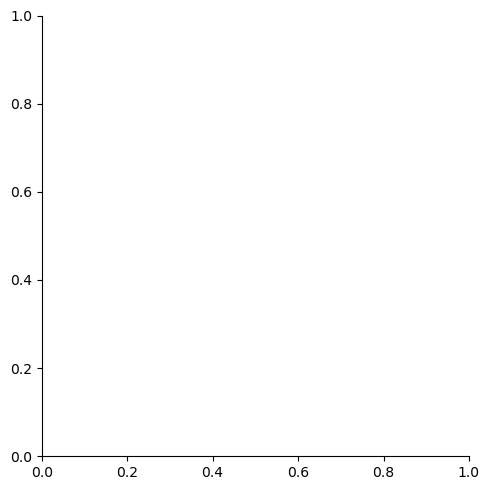

In [10]:
import seaborn as sns
sns.displot(data=df, x="duration", y="reduction", 
            hue="solver", kind="kde")


In [9]:
!pip install seaborn

/home/asem/GP/env/icenode-dev/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
